<div >
<img src = "../banner.jpg" />
</div>

# Aplications


-   To illustrate how it works let me use this experiment from the General Social Survey (GSS)

-   GSS conducts surveys regular surveys on Americans think feel about different issues

-   For decades, scholars studying Americans' support for social welfare spending have noted the special disdain that americans harbor for programs labeled "welfare"

-   This phenomenon became the subject of sustained experimental inquiry in the mid-1980s, when the GSS included a question-wording experiment in its national survey of adults.


-   Respondents in each survey were randomly assigned to one of two questions about public spending.

-   *"too much" money is spent on assistance to the Poor (treatment) or Welfare (control)*

-   Various explanations put forward: stereotypes associated with welfare recipients and poor people, particularly racial stereotypes, and to political orientations such as individualism and conservatism .


## Loading packages

Let's load the packages

In [27]:
set.seed(201911) 

require("pacman")
p_load("tidyverse",# Data wrangling       
        "fBasics",     # Summary statistics 
        "corrplot",    # Correlations 
        "psych",       # Correlation p-values 
        "hdm"         # High-Dimensional Metrics
)


## Loading the data

We will be working with the `welfare` dataset, from "Modeling Heterogeneous Treatment Effects in Survey Experiments with Baysian Additive Regression Trees" (Green and Kern, 2012) ).

Next, we load in the raw data and perform some data cleaning.

In [28]:
# R script for reading data from github repository, set path to where you have the tutorial files saved.
df_experiment<-readRDS(url("https://github.com/ignaciomsarmiento/datasets/raw/main/welfare.rds"))


In [29]:
head(df_experiment)

,ID,Y,W,hrs1,partyid,income,rincome,wrkstat,wrkslf,age,...,parborn,maeduc,degree,sex,born,hompop,babies,preteen,teens,adults
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,1,40,4,12,11,1,2,29,...,0,16,3,2,1,2,0,0,0,2
2,2,0,1,35,1,12,12,1,2,48,...,0,20,3,2,1,1,0,0,0,1
3,3,1,1,30,2,12,9,1,2,27,...,0,8,1,2,1,2,0,0,0,2
4,4,1,0,40,2,12,12,1,2,27,...,8,4,1,2,1,2,0,1,0,1
5,5,1,0,35,1,11,11,1,2,24,...,0,12,2,1,1,1,0,0,0,1
6,6,0,1,38,2,12,12,1,2,24,...,8,9,0,1,1,4,1,1,0,2


## Cleaning the data

Let's do some minimal housekeeping. First, we will drop the columns that aren't outcomes, treatments or (pre-treatment) covariates, since we won't be using those.


In [30]:
covariate_names<- c("hrs1", "partyid", "income", "rincome", "wrkstat", "wrkslf", "age", "polviews", "educ", "earnrs", "race", "marital", "sibs", "childs", "occ80", "prestg80", "indus80", "res16", "reg16", "mobile16", "family16", "parborn", "maeduc", "degree", "sex", "born", "hompop", "babies", "preteen", "teens", "adults")

In [31]:
# Combine all names
all_variables_names <- c("Y", "W", covariate_names)
df <- df_experiment %>% select(all_of(all_variables_names))

Next, let's drop any row that has missing values in them.

In [32]:
# Drop rows containing missing values
df <- df %>% drop_na()

Some of the methods below don't accept `factor` variables, so let's change their type to `numeric` here. 

In [33]:
# Converting all columns to numerical and add row id
df <- data.frame(lapply(df, function(x) as.numeric(as.character(x))))

df <- df %>% mutate_if(is.character,as.numeric)
df <- df %>% rowid_to_column( "ID")

head(df)

,ID,Y,W,hrs1,partyid,income,rincome,wrkstat,wrkslf,age,...,parborn,maeduc,degree,sex,born,hompop,babies,preteen,teens,adults
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,1,40,4,12,11,1,2,29,...,0,16,3,2,1,2,0,0,0,2
2,2,0,1,35,1,12,12,1,2,48,...,0,20,3,2,1,1,0,0,0,1
3,3,1,1,30,2,12,9,1,2,27,...,0,8,1,2,1,2,0,0,0,2
4,4,1,0,40,2,12,12,1,2,27,...,8,4,1,2,1,2,0,1,0,1
5,5,1,0,35,1,11,11,1,2,24,...,0,12,2,1,1,1,0,0,0,1
6,6,0,1,38,2,12,12,1,2,24,...,8,9,0,1,1,4,1,1,0,2


---

## Descriptive statistics

It's often useful to begin data analysis by simply looking at simple summary statistics. We use the function `basicStats` from the package `fBasics` to calculate them.

In [34]:
# Make a data.frame containing summary statistics of interest
summ_stats <- fBasics::basicStats(df)
summ_stats <- as.data.frame(t(summ_stats))
# Rename some of the columns for convenience
summ_stats <- summ_stats %>% select("Mean", "Stdev", "Minimum", "1. Quartile", "Median",  "3. Quartile", "Maximum")
summ_stats <- summ_stats %>% rename('Lower quartile'= '1. Quartile', 'Upper quartile' ='3. Quartile')

In [35]:
summ_stats

,Mean,Stdev,Minimum,Lower quartile,Median,Upper quartile,Maximum
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ID,6599.500000,3810.078761,1,3300.25,6599.5,9898.75,13198
Y,0.290423,0.453975,0,0.00,0.0,1.00,1
W,0.514245,0.499816,0,0.00,1.0,1.00,1
hrs1,42.258827,14.006607,0,38.00,40.0,50.00,89
partyid,2.947719,2.033141,0,1.00,3.0,5.00,7
income,11.292469,1.646972,1,11.00,12.0,12.00,12
rincome,10.204501,2.750699,1,9.00,12.0,12.00,12
wrkstat,1.156312,0.363164,1,1.00,1.0,1.00,2
wrkslf,1.875511,0.330151,1,2.00,2.0,2.00,2


Presenting pairwise correlations is easy with the `corrplot` function from the `corrplot` package. On the table below, if the (unadjusted) p-value for a pair of variables is less than 0.05, its square is not colored.

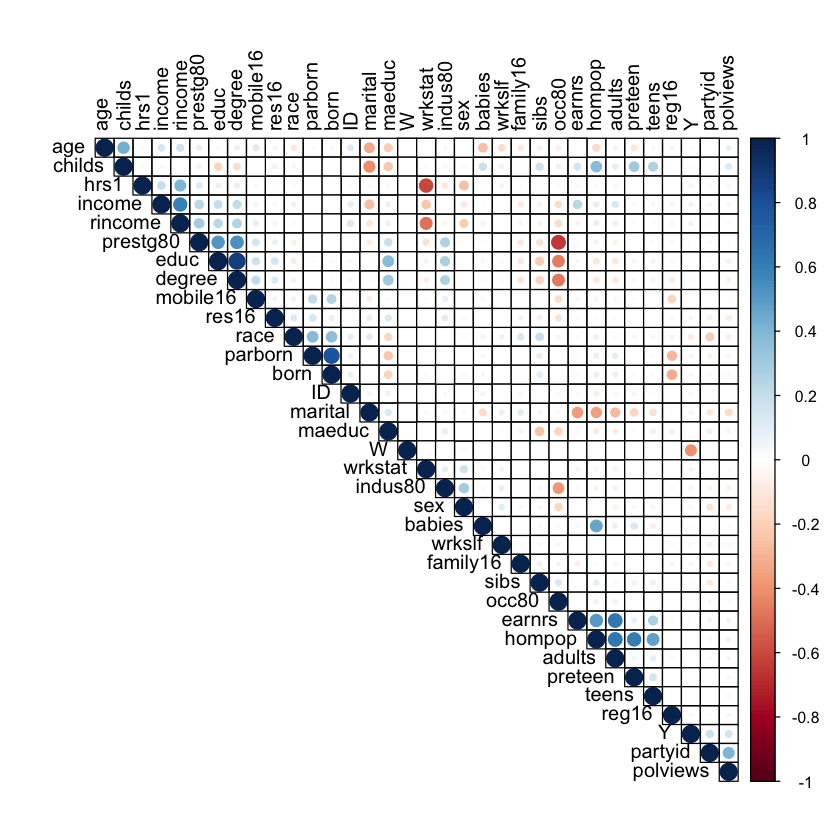

In [36]:
# Note: if the plot looks too cramped, try increasing fig.width and fig.height in the line above
pairwise_pvalues <- psych::corr.test(df, df)$p
corrplot(cor(df),
        type="upper",
        tl.col="black",
        order="hclust",
        tl.cex=1,
        addgrid.col = "black",
        p.mat=pairwise_pvalues,
        sig.level=0.05,
        number.font=10,
        insig="blank")

# PART I: ATE y CATE

 *"too much" money is spent on assistance to the Poor (treatment) or Welfare (control)*

In [37]:
tapply(df$Y,df$W,mean)

0         1 
0.4805803 0.1108001

- 48% agree that too much money is spent on Welfare
- 11% agree that too much money is spent on assistance to the Poor

In [38]:
difference_in_means <- function(dataset) {
  # Filter treatment / control observations, pulls outcome variable as a vector
  y1 <- dataset %>% dplyr::filter(W == 1) %>% dplyr::pull(Y) # Outcome in treatment grp
  y0 <- dataset %>% dplyr::filter(W == 0) %>% dplyr::pull(Y) # Outcome in control group
  
  n1 <- sum(df[,"W"])     # Number of obs in treatment
  n0 <- sum(1 - df[,"W"]) # Number of obs in control
  
  # Difference in means is ATE
  tauhat <- mean(y1) - mean(y0)
  
  # 95% Confidence intervals
  se_hat <- sqrt( var(y0)/(n0-1) + var(y1)/(n1-1) )
  lower_ci <- tauhat - 1.96 * se_hat
  upper_ci <- tauhat + 1.96 * se_hat
  
  return(c(ATE = tauhat, lower_ci = lower_ci, upper_ci = upper_ci))
}

tauhat_rct <- difference_in_means(df)
tauhat_rct

ATE   lower_ci   upper_ci 
-0.3697802 -0.3841123 -0.3554481

In [39]:
ols_ate <- lm(Y~W, data=df)

In [40]:
fmla <- as.formula(paste("Y ~ W +", paste(covariate_names, collapse= "+")))
ols_cate <- lm(fmla, data=df)
stargazer::stargazer(ols_ate,ols_cate,type="text",digits = 5)


                                        Dependent variable:                     
                    ------------------------------------------------------------
                                                 Y                              
                                 (1)                            (2)             
--------------------------------------------------------------------------------
W                            -0.36978***                    -0.36787***         
                              (0.00722)                      (0.00702)          
                                                                                
hrs1                                                        0.00105***          
                                                             (0.00033)          
                                                                                
partyid                                                     0.02694***          
                           

Second, we estimate the effect by the partialling out by Post-Lasso: 


In [41]:
Y <- df$Y
W <- df$W

In [42]:
X <- as.matrix(df[covariate_names])
head(X)

hrs1,partyid,income,rincome,wrkstat,wrkslf,age,polviews,educ,earnrs,...,parborn,maeduc,degree,sex,born,hompop,babies,preteen,teens,adults
40,4,12,11,1,2,29,5,16,2,...,0,16,3,2,1,2,0,0,0,2
35,1,12,12,1,2,48,2,17,0,...,0,20,3,2,1,1,0,0,0,1
30,2,12,9,1,2,27,3,12,2,...,0,8,1,2,1,2,0,0,0,2
40,2,12,12,1,2,27,3,13,1,...,8,4,1,2,1,2,0,1,0,1
35,1,11,11,1,2,24,2,14,1,...,0,12,2,1,1,1,0,0,0,1
38,2,12,12,1,2,24,3,10,1,...,8,9,0,1,1,4,1,1,0,2


In [43]:
lasso.effect <- rlassoEffect(x=X, y=Y, d=W, method="partialling out")
summary(lasso.effect)

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
[1,] -0.367163   0.007025  -52.27   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Third, we estimate the effect by the double selection method:


In [44]:
doublesel.effect <- rlassoEffect(x=X, y=Y, d=W, method="double selection")
summary(doublesel.effect)

[1] "Estimates and significance testing of the effect of target variables"
   Estimate. Std. Error t value Pr(>|t|)    
d1 -0.367373   0.007124  -51.57   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Warning message in ggplot2::geom_hline(colour = col, ggplot2::aes(width = 0.1, h = 0, :
"Ignoring unknown aesthetics: width and h"
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_hline()`)."


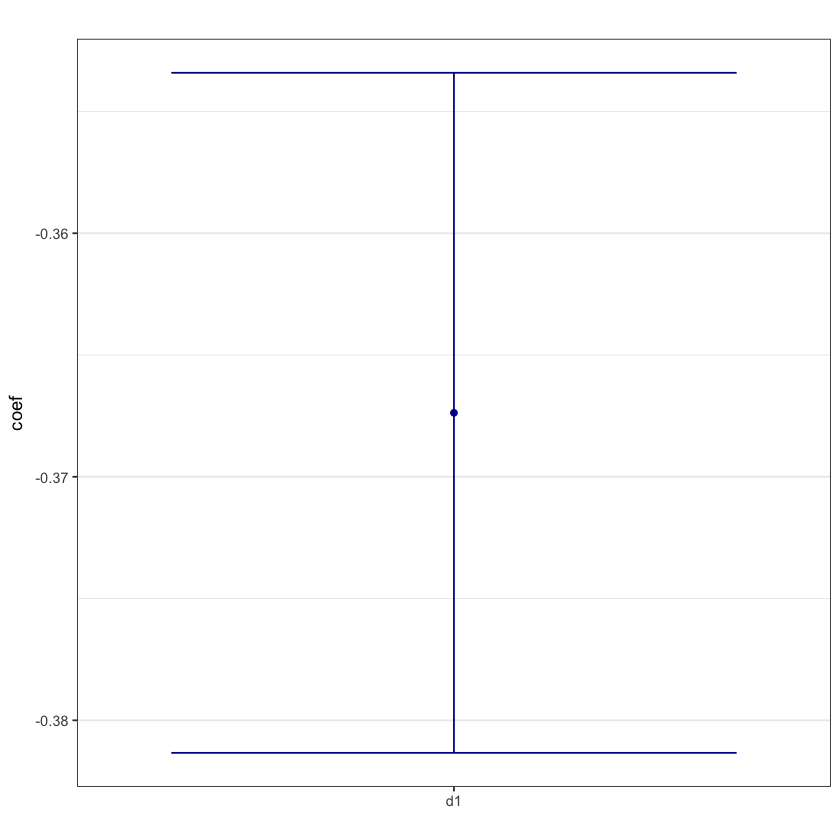

In [46]:
plot(doublesel.effect)

In [ ]:
data.frame(doublesel.effect$selection.index)

----